# HW1 - Representation Learning and Evaluation
### Full-Name: Amir Mohammad Babaei
### Student Number: 402212399

In this notebook, we will analyze and evaluate the OpenAI CLIP model. We recommend reviewing relevant materials on CLIP before proceeding ([link](https://openai.com/research/clip)), as this notebook assumes a basic understanding of the model.

Additionally, using Google Colab is highly recommended for your convenience due to its pre-configured environment.

# Install Requirements

In [ ]:
! pip install transformers datasets
! pip install --extra-index-url=https://pypi.nvidia.com cuml-cu12==24.2.*

# Import

In [ ]:
import functools
import random
import itertools
from typing import List, Optional
from collections import defaultdict

import PIL
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from PIL import Image
from datasets import load_dataset
from matplotlib import colors as mcolors, pyplot as plt, ticker
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
from transformers import AutoProcessor, CLIPConfig, CLIPModel, CLIPProcessor

from cuml.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_distances

# Config

In [ ]:
default_prompt_template = 'a photo of {}, a type of food.'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Utils

In [ ]:
def torch_decorator(device=None, no_grad=False):
    def decorator(func):
        @functools.wraps(func)
        def wrapper(*args, **kwargs):
            new_args = [arg.to(device) if isinstance(arg, torch.Tensor) else arg for arg in args] if device else args
            new_kwargs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in kwargs.items()} if device else kwargs
            result = None
            try:
                if no_grad:
                    with torch.no_grad():
                        result = func(*new_args, **new_kwargs)
                else:
                    result = func(*new_args, **new_kwargs)
                return result
            finally:
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        return wrapper
    return decorator

def describe_model(model, display_nested=True):
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total model parameters: {total_params:,}")
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable model parameters: {trainable_params:,}")
    frozen_params = total_params - trainable_params
    print(f"Frozen model parameters: {frozen_params:,}")
    print()
    for name, module in model._modules.items():
        print(f"Attribute Name: {name}, Type: {type(module).__name__}")
        if display_nested:
            for sub_name, sub_module in module._modules.items():
                print(f"-    Attribute Name: {sub_name}, Type: {type(sub_module).__name__}")
        print()
    print(f'Device: {next(model.parameters()).device}')
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    size_all_mb = (param_size + buffer_size) / 1024**2
    print('model size: {:.3f}MB'.format(size_all_mb))

def plot_accuracy_histogram(accuracies, top_k):
    assert len(accuracies) == len(top_k), "Length of accuracies must match length of top_k"
    x_labels = [f"Top-{k}" for k in top_k]
    plt.figure(figsize=(20, 8))
    plt.plot(x_labels, accuracies, color='royalblue', marker='o', linestyle='-', linewidth=2, markersize=8)
    plt.grid(color='gray', linestyle='--', linewidth=0.5)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.title("Zero Shot Performance", fontsize=20)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter())
    for i, txt in enumerate(accuracies):
        plt.annotate(f"{txt:.2f}%", (x_labels[i], accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center', fontsize=12)
    plt.tight_layout()
    plt.show()

def create_accuracy_dataframe(class_wise_accuracies, top_k, imagenet_classes_df):
    fine_grained_acc_df = pd.DataFrame({'class_id': range(len(class_wise_accuracies[top_k[0]]))})
    for k in top_k:
        fine_grained_acc_df[f'top{k}_acc'] = class_wise_accuracies[k]
    fine_grained_acc_df = pd.merge(fine_grained_acc_df, imagenet_classes_df[['class_id', 'node_id', 'target', 'coarse-grained']], on='class_id')
    fine_grained_acc_df['acc_diff'] = fine_grained_acc_df['top5_acc'] - fine_grained_acc_df['top1_acc']
    fine_grained_acc_df['class_id'] = fine_grained_acc_df['class_id'].astype(int)
    fine_grained_acc_df['node_id'] = fine_grained_acc_df['node_id'].astype(int)
    return fine_grained_acc_df

def accuracy(output, target, topk=(1,)):
    pred = output.topk(max(topk), 1, True, True)[1].t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    return [float(correct[:k].reshape(-1).float().sum(0, keepdim=True).cpu().numpy()) for k in topk]

# Load Model

In [ ]:
class HuggingFaceCLIP(torch.nn.Module):
    def __init__(self, model_name="openai/clip-vit-base-patch32", device="cuda"):
        super().__init__()
        self.device = torch.device(device)
        self.to(self.device)
        self.config = CLIPConfig.from_pretrained(model_name)
        self.model = CLIPModel(self.config).to(self.device)
        self.processor = AutoProcessor.from_pretrained(model_name)
        self.model.eval()

    def get_logit_scale(self):
        return self.model.logit_scale.exp()

    def preprocess_text(self, texts: List[str], preprocess=True):
        if preprocess:
            return self.processor(text=texts, return_tensors="pt", padding=True, truncation=True)
        else:
            return texts

    def preprocess_image(self, images, preprocess=True):
        if preprocess:
            return self.processor(images=images, return_tensors="pt")['pixel_values']
        else:
            return images

    def compute_text_embeddings(self, texts, normalize=True, with_grad=True, preprocess=True):
        with torch.set_grad_enabled(with_grad):
            if preprocess:
                inputs = self.preprocess_text(texts, preprocess=preprocess)
            else:
                inputs = texts

            inputs = inputs.to(self.device)
            text_features = self.model.get_text_features(**inputs)
            if normalize:
                text_features = text_features / text_features.norm(dim=1, keepdim=True)
        return text_features

    def compute_image_embeddings(self, images, normalize=True, with_grad=True, preprocess=True):
        with torch.set_grad_enabled(with_grad):
            if preprocess:
                inputs = self.preprocess_image(images, preprocess=preprocess)
            else:
                inputs = images
            inputs = inputs.to(self.device)
            image_features = self.model.get_image_features(inputs)
            if normalize:
                image_features = image_features / image_features.norm(dim=1, keepdim=True)
        return image_features

    def compute_logits(self, texts, images, with_grad=True, prob=True, preprocess_text=True, preprocess_image=True):
        with torch.set_grad_enabled(with_grad):
            text_embeddings = self.compute_text_embeddings(texts, normalize=True, with_grad=with_grad, preprocess=preprocess_text)
            image_embeddings = self.compute_image_embeddings(images, normalize=True, with_grad=with_grad, preprocess=preprocess_image)

            logit_scale = self.get_logit_scale()
            logits_per_image = logit_scale * image_embeddings @ text_embeddings.t()
            if prob:
                logits_per_image = logits_per_image.softmax(dim=-1)
        return logits_per_image

    def to_device(self, device: str):
        self.device = torch.device(device)
        self.to(self.device)

    def save(self, path: str):
        torch.save(self.state_dict(), path)

    def load(self, path: str):
        self.load_state_dict(torch.load(path))

vlm = HuggingFaceCLIP()
describe_model(vlm)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Total model parameters: 151,277,313
Trainable model parameters: 151,277,313
Frozen model parameters: 0

Attribute Name: model, Type: CLIPModel
-    Attribute Name: text_model, Type: CLIPTextTransformer
-    Attribute Name: vision_model, Type: CLIPVisionTransformer
-    Attribute Name: visual_projection, Type: Linear
-    Attribute Name: text_projection, Type: Linear

Device: cuda:0
model size: 577.078MB


# Load Dataset

## Food101

This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.

In [ ]:
raw_dataset = load_dataset("food101", revision="main", split='validation')
raw_dataset

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 25250
})

In [ ]:
# random downsampling
class FoodDataset(Dataset):
    def __init__(self, dataset: dict):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

TO_KEEP_COUNT = 5000
total_samples = len(raw_dataset)
to_keep_indices = random.sample(range(total_samples), TO_KEEP_COUNT)
reduced_dict = [raw_dataset[i] for i in to_keep_indices]
dataset = FoodDataset(reduced_dict)

In [ ]:
labels = ["Apple pie", "Baby back ribs", "Baklava", "Beef carpaccio", "Beef tartare", "Beet salad", "Beignets", "Bibimbap", "Bread pudding", "Breakfast burrito", "Bruschetta", "Caesar salad", "Cannoli", "Caprese salad", "Carrot cake", "Ceviche", "Cheesecake", "Cheese plate", "Chicken curry", "Chicken quesadilla", "Chicken wings", "Chocolate cake", "Chocolate mousse", "Churros", "Clam chowder", "Club sandwich", "Crab cakes", "Creme brulee", "Croque madame", "Cup cakes", "Deviled eggs", "Donuts", "Dumplings", "Edamame", "Eggs benedict", "Escargots", "Falafel", "Filet mignon", "Fish and chips", "Foie gras", "French fries", "French onion soup", "French toast", "Fried calamari", "Fried rice", "Frozen yogurt", "Garlic bread", "Gnocchi", "Greek salad", "Grilled cheese sandwich", "Grilled salmon", "Guacamole", "Gyoza", "Hamburger", "Hot and sour soup", "Hot dog", "Huevos rancheros", "Hummus", "Ice cream", "Lasagna", "Lobster bisque", "Lobster roll sandwich", "Macaroni and cheese", "Macarons", "Miso soup", "Mussels", "Nachos", "Omelette", "Onion rings", "Oysters", "Pad thai", "Paella", "Pancakes", "Panna cotta", "Peking duck", "Pho", "Pizza", "Pork chop", "Poutine", "Prime rib", "Pulled pork sandwich", "Ramen", "Ravioli", "Red velvet cake", "Risotto", "Samosa", "Sashimi", "Scallops", "Seaweed salad", "Shrimp and grits", "Spaghetti bolognese", "Spaghetti carbonara", "Spring rolls", "Steak", "Strawberry shortcake", "Sushi", "Tacos", "Takoyaki", "Tiramisu", "Tuna tartare", "Waffles"]
annotation_df = pd.DataFrame({
    'label': labels,
    'class_id': range(len(labels))
})

class_id_to_label = pd.Series(annotation_df.label.values, index=annotation_df.class_id).to_dict()
annotation_df.head()

,label,class_id
0,Apple pie,0
1,Baby back ribs,1
2,Baklava,2
3,Beef carpaccio,3
4,Beef tartare,4


# Create Embedding Dataset

In [ ]:
class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        embedding = self.embeddings[idx]
        label = self.labels[idx]
        return embedding, label

@torch_decorator(device=device, no_grad=True)
def create_label_embeddings_dataset(vlm, target_id_to_target, templates, aggregate=False, device=device):
    all_embeddings, all_ids = [], []
    for target_id, target in tqdm(target_id_to_target.items()):
        texts = [template.format(target) for template in templates]
        embeddings = vlm.compute_text_embeddings(texts, normalize=True, with_grad=False).cpu()
        if aggregate:
            all_embeddings.append(embeddings.mean(dim=0))
            all_ids.append(target_id)
        else:
            for j in range(len(texts)):
                all_embeddings.append(embeddings[j])
            all_ids.extend([target_id] * len(texts))

    all_embeddings = torch.stack(all_embeddings, dim=0)
    all_embeddings = all_embeddings / all_embeddings.norm(dim=-1, keepdim=True)
    return EmbeddingDataset(all_embeddings.squeeze(), all_ids)

@torch_decorator(device=device, no_grad=True)
def create_image_embeddings_dataset(vlm, dataset, batch_size=2048, device=device):
    all_embeddings, all_ids = torch.tensor([]), []
    dataset_len = len(dataset)
    for idx in tqdm(range(0, dataset_len-1, batch_size)):
        end_index = min(idx + batch_size + 1, dataset_len)
        indices = list(range(idx, end_index))
        items = [dataset[i] for i in indices]
        images = [x['image'] for x in items]
        class_ids = [int(x['label']) for x in items]

        image_embeddings = vlm.compute_image_embeddings(images, normalize=True, with_grad=False).cpu()

        all_embeddings = torch.concatenate([all_embeddings, image_embeddings], axis=0)
        all_ids.extend(class_ids)

    return EmbeddingDataset(all_embeddings.squeeze(), all_ids)

In [ ]:
label_embeddings_dataset = create_label_embeddings_dataset(vlm, class_id_to_label, templates=[default_prompt_template])
image_embeddings_dataset = create_image_embeddings_dataset(vlm, dataset)

100%|██████████| 3/3 [01:17<00:00, 25.75s/it]


In [ ]:
print(f'{len(label_embeddings_dataset)=}')
print(f'{len(image_embeddings_dataset)=}')

len(label_embeddings_dataset)=101
len(image_embeddings_dataset)=5002


In [ ]:
image_loader = DataLoader(image_embeddings_dataset, batch_size=256, shuffle=False)
label_loader = DataLoader(label_embeddings_dataset, batch_size=1024, shuffle=False)

# Zero-shot Accuracy

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-13-1f844985d229>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(class_ids).cpu()
100%|██████████| 20/20 [00:00<00:00, 31.35it/s]


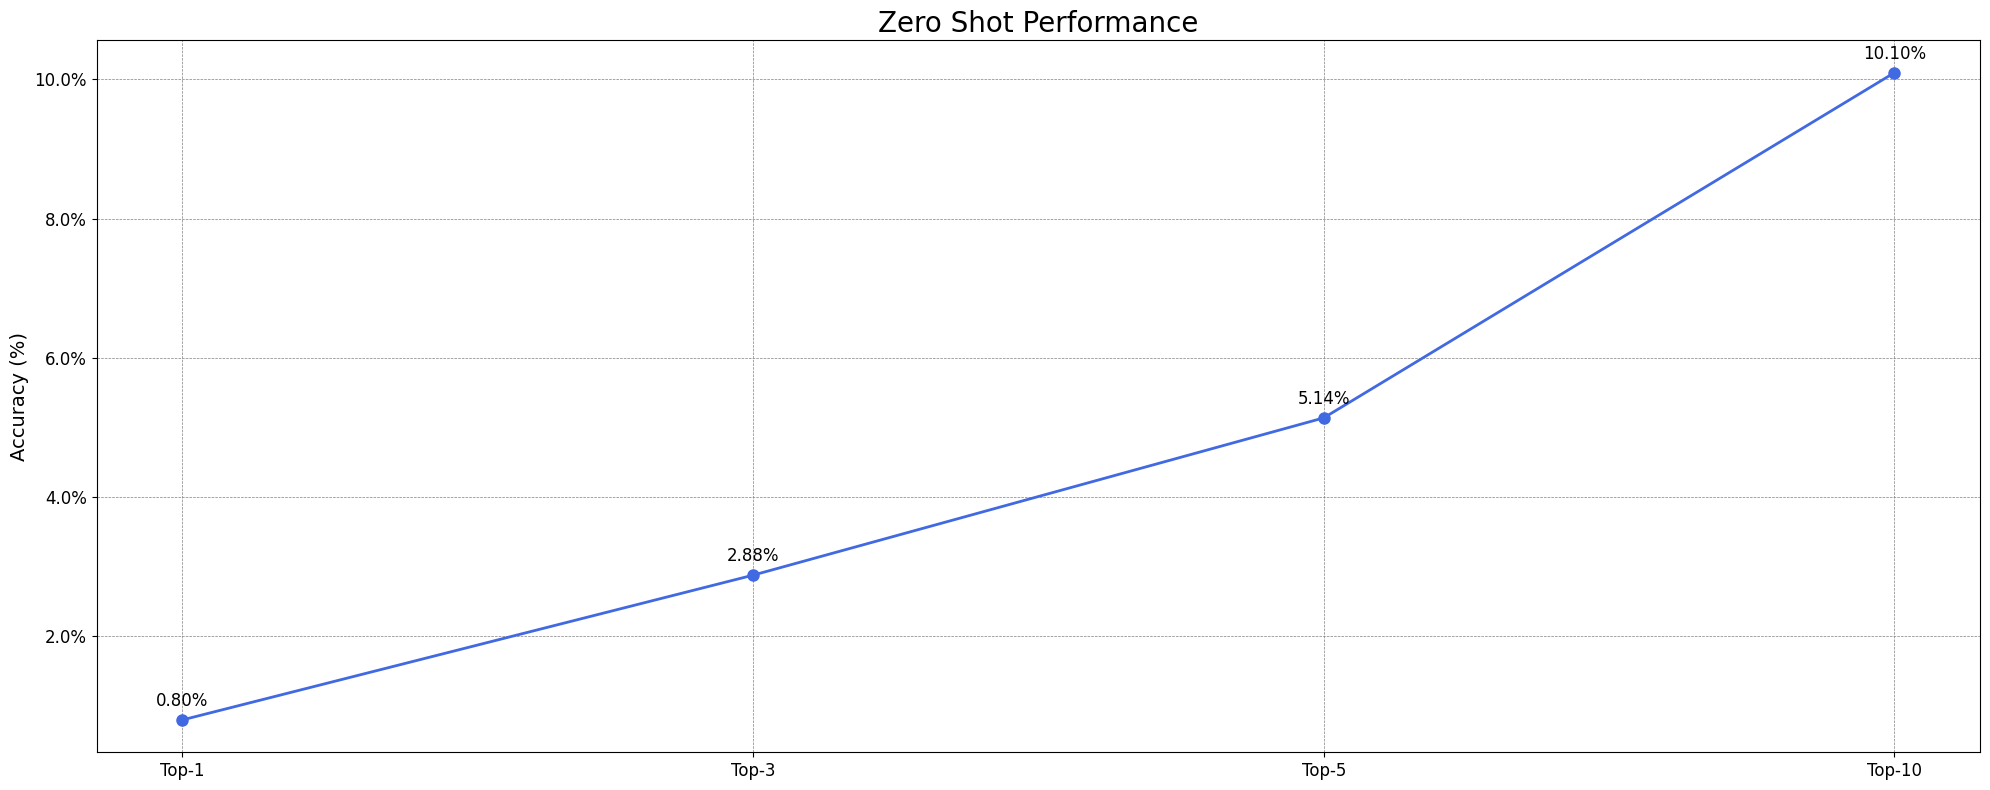

In [ ]:
@torch_decorator(device=device, no_grad=True)
def get_zero_shot_performance(image_loader, label_loader, vlm, top_k):
    n, num_classes = 0, len(label_loader.dataset.labels)
    num_queries_per_label = label_loader.dataset.embeddings.shape[0] // num_classes
    n = 0
    top_k_accuracies = {k: 0. for k in top_k}
    class_wise_accuracies = {k: torch.zeros(num_classes) for k in top_k}
    class_counts = torch.zeros(num_classes)
    logit_scale = vlm.get_logit_scale().cpu()

    label_embeddings =  torch.transpose(label_loader.dataset.embeddings, 0, 1).float().cpu()

    for images, class_ids in tqdm(image_loader):
        images = images.float().cpu()
        target = torch.tensor(class_ids).cpu()
        image_features = images / images.norm(dim=-1, keepdim=True)
        target_embeddings = []

        logits = (logit_scale * image_features @ label_embeddings).view(images.shape[0], num_classes, num_queries_per_label)
        logits = torch.mean(logits, dim=2).softmax(dim=-1)
        acc = accuracy(logits, target, topk=top_k)
        for idx, k in enumerate(top_k):
            top_k_accuracies[k] += acc[idx]

        for i in range(target.size(0)):
            class_counts[target[i]] += 1
            for k in top_k:
                if target[i] in logits[i].topk(k).indices:
                    class_wise_accuracies[k][target[i]] += 1

        n += images.size(0)

    for k in top_k:
        top_k_accuracies[k] = (top_k_accuracies[k] / n) * 100
        class_wise_accuracies[k] = (class_wise_accuracies[k] / (class_counts * num_queries_per_label)) * 100

    return top_k_accuracies, class_wise_accuracies

top_k =(1, 3, 5, 10)

top_k_accuracies, class_wise_top_k_accuracies = get_zero_shot_performance(
    image_loader,
    label_loader,
    vlm,
    top_k=top_k,
)

plot_accuracy_histogram(list(top_k_accuracies.values()), top_k)

# Visualize Image & Text Embeddings

### Use cuML's TSNE

### Why cuML?

- **GPU acceleration:** cuML leverages the parallel processing capabilities of GPUs, significantly accelerating machine learning algorithms compared to CPU-based libraries. This translates to faster training and inference times, especially for large datasets.
- **Sklearn-like API:** If you're familiar with scikit-learn, the transition to cuML is seamless. Its intuitive API mirrors scikit-learn's, allowing you to apply your existing knowledge and code structure with minimal modifications. This simplifies the adoption of GPU acceleration for your existing workflows.
- **Ease of use:** cuML eliminates the need for explicit GPU programming. You can leverage its functionalities through familiar Python code, focusing on your machine learning tasks without delving into low-level GPU development.

### Task (10 points)

In [ ]:
torch.cat([images_list[0] for images_list in image_loader]).shape

torch.Size([5002, 512])

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


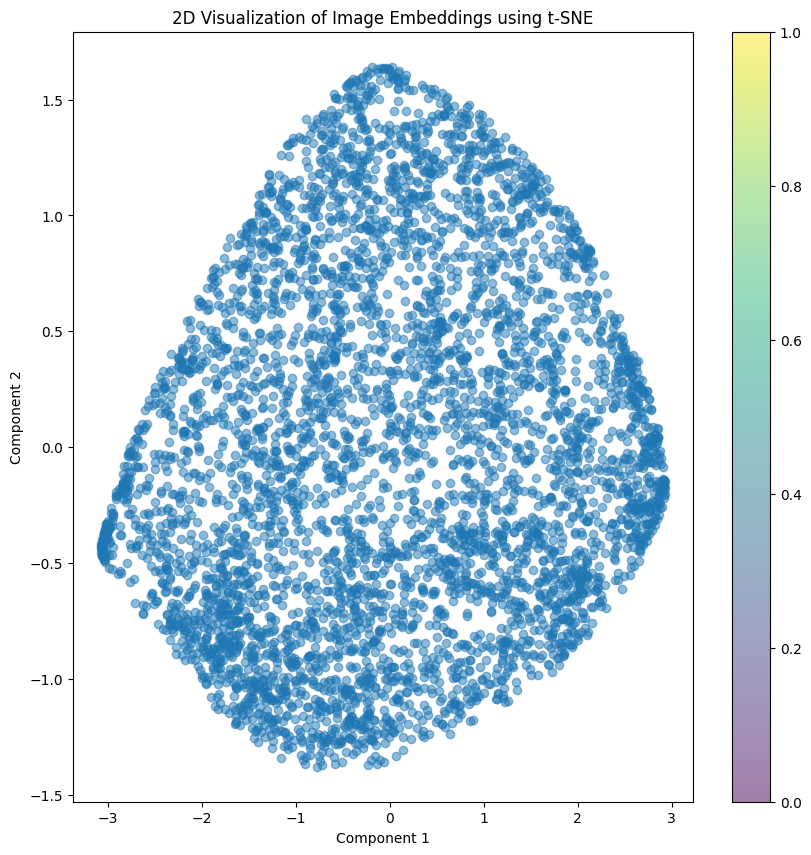

In [ ]:
# TODO: Visualize Image Embeddings (5 points)

# Declare a fixed seed for reproducibility reason
SEED = 42

# Initial images embeddings
image_embeddings = torch.cat([images_list[0] for images_list in image_loader])
image_embeddings = image_embeddings.cpu().numpy()

# Dimensionality Reduction with t-SNE
tsne_model = TSNE(n_components=2, random_state=SEED, perplexity=30, learning_rate=200)
image_embeddings_2d = tsne_model.fit_transform(image_embeddings)

# Visualization
plt.figure(figsize=(10, 10))
plt.scatter(image_embeddings_2d[:, 0], image_embeddings_2d[:, 1], alpha=0.5)
plt.title('2D Visualization of Image Embeddings using t-SNE')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.show()

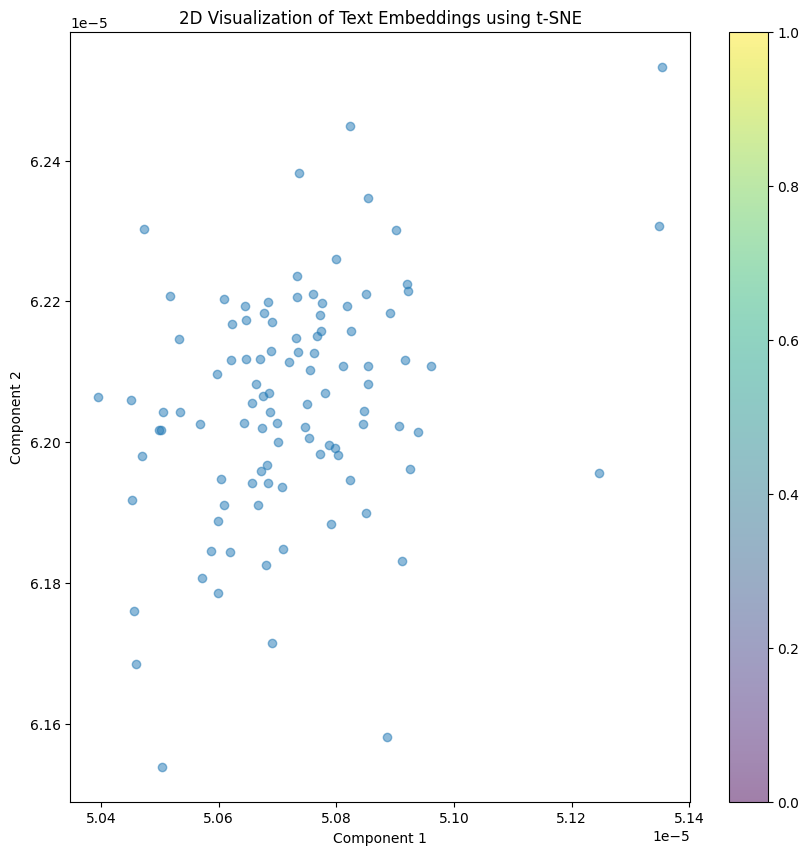

In [ ]:
# TODO: Visualize Text Embeddings (5 points)

# Initial texts embeddings
text_embeddings = torch.cat([texts_list[0] for texts_list in label_loader])
text_embeddings = text_embeddings.cpu().numpy()

# Dimensionality Reduction with t-SNE
tsne_model = TSNE(n_components=2, random_state=SEED, perplexity=30, learning_rate=200)
text_embeddings_2d = tsne_model.fit_transform(text_embeddings)

# Visualization
plt.figure(figsize=(10, 10))
plt.scatter(text_embeddings_2d[:, 0], text_embeddings_2d[:, 1], alpha=0.5)
plt.title('2D Visualization of Text Embeddings using t-SNE')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.colorbar()
plt.show()

# Image Embedding Analytics

##  Consistency

**Definition:** Consistency measures the degree to which data points with similar latent representations share consistent class labels.

### Task (50 points)

1. For each data point, calculate the fraction of its k nearest neighbors (k-NN) in the embedding space whose class labels are consistent with the data point itself.
2. Calculate the average consistency for each class, as well as the overall average consistency across all classes in the dataset. __Report these values and visualize the histogram.__
3. Identify the top 3 classes with the **lowest** and **highest** consistency scores.
4. Compare these class-wise consistency scores with the corresponding zero-shot accuracy performance.
5. Based on the comparison, draw conclusions about the relationship between consistency and zero-shot accuracy in this specific scenario.

**Note:**
* Report your result for __k=5 & k=15__.

In [ ]:
def calculate_consistency(dataloader, class_labels, k: int):
    embeddings = torch.cat([data_item[0] for data_item in dataloader])
    labels = torch.cat([data_item[1] for data_item in dataloader])
    embeddings = embeddings.cpu().numpy()

    knn = NearestNeighbors(n_neighbors=k+1, algorithm='auto').fit(embeddings)
    distances, indices = knn.kneighbors(embeddings)

    total_consistency = 0
    consistencies = defaultdict(list)

    # Calculate consistency
    for idx, neighbors in enumerate(indices):
        # Exclude the point itself
        neighbor_labels = [labels[n] for n in neighbors if n != idx]
        consistency = neighbor_labels.count(labels[idx]) / k
        consistencies[labels[idx]].append(consistency)
        total_consistency += consistency

    # print(f'{total_consistency=}, {len(embeddings)}')
    avg_consistency = total_consistency / len(embeddings)
    class_consistency = {class_labels[k.item()]:(sum(v)/len(v) if len(v) > 0 else 0) for k, v in consistencies.items()}

    return avg_consistency, class_consistency

In [ ]:
def plot_consistency(class_consistency):
    # Extract class names and their corresponding average consistencies
    class_names = list(class_consistency.keys())
    avg_consistencies = list(class_consistency.values())

    # Creating the bar plot
    plt.figure(figsize=(10, 6)) # Adjust the figure size as necessary
    plt.bar(class_names, avg_consistencies, color='skyblue')

    plt.xlabel('Class Name')
    plt.ylabel('Average Consistency')
    plt.title('Average Consistency of Each Class')
    plt.xticks(rotation=45) # Rotate class names for better visibility if necessary
    plt.ylim(0, 1) # Assuming consistency values are between 0 and 1

    # Adding the average consistency values above the bars
    for i, avg in enumerate(avg_consistencies):
        plt.text(i, avg + 0.02, f'{avg:.2f}', ha='center')

    plt.tight_layout()
    plt.show()

In [ ]:
def find_extreme_classes_consistency(avg_class_consistency):
    sorted_consistency = sorted(avg_class_consistency.items(), key=lambda x: x[1])
    lowest = sorted_consistency[:3]
    highest = sorted_consistency[-3:][::-1]
    return highest, lowest

avg_consistency_5=0.017952818872451135
class_consistency_5={'French fries': 0.2, 'Takoyaki': 0.0, 'Macaroni and cheese': 0.0, 'Croque madame': 0.0, 'Guacamole': 0.0, 'Gnocchi': 0.0, 'Chicken quesadilla': 0.0, 'Frozen yogurt': 0.0, 'Huevos rancheros': 0.0, 'Risotto': 0.0, 'Red velvet cake': 0.0, 'Oysters': 0.0, 'Falafel': 0.0, 'Cup cakes': 0.0, 'Shrimp and grits': 0.0, 'Grilled salmon': 0.0, 'Apple pie': 0.0, 'Samosa': 0.0, 'Filet mignon': 0.0, 'Pho': 0.0, 'Peking duck': 0.0, 'Baklava': 0.0, 'Pancakes': 0.0, 'Omelette': 0.0, 'Tiramisu': 0.0, 'Spaghetti bolognese': 0.0, 'Seaweed salad': 0.2, 'Creme brulee': 0.0, 'Prime rib': 0.0, 'Edamame': 0.0, 'Crab cakes': 0.0, 'Ramen': 0.0, 'Bread pudding': 0.0, 'Chocolate cake': 0.2, 'Fish and chips': 0.0, 'Sashimi': 0.0, 'Fried calamari': 0.0, 'Lasagna': 0.0, 'Deviled eggs': 0.0, 'Nachos': 0.0, 'Chocolate mousse': 0.0, 'Spring rolls': 0.0, 'Beignets': 0.2, 'Club sandwich': 0.0, 'French toast': 0.0, 'Pizza': 0.0, 'Waffles': 0.0, 'Caesar salad': 0.0,

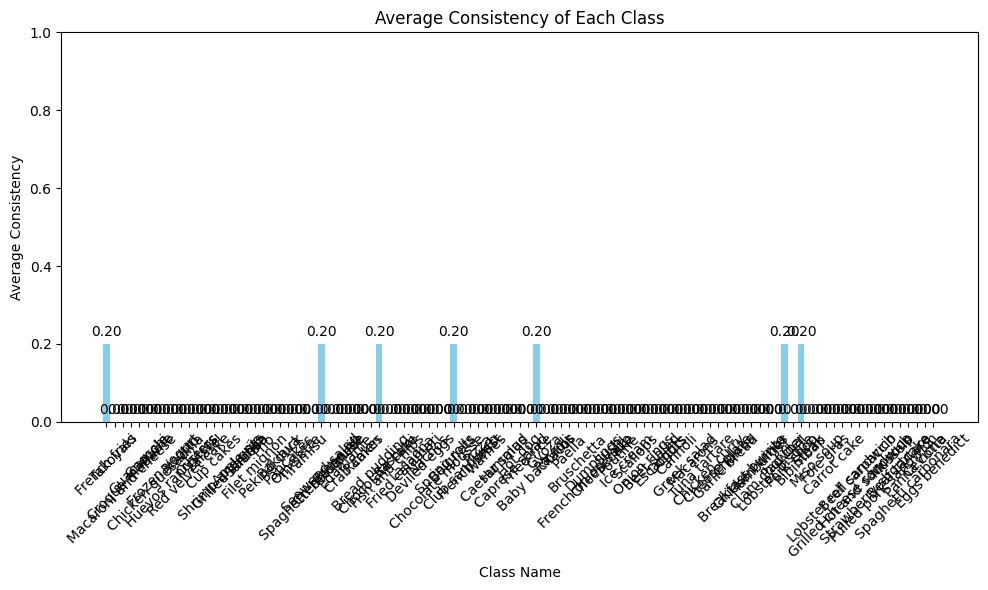

In [ ]:
# Conclusion & Report

# k = 5
avg_consistency_5, class_consistency_5 = calculate_consistency(image_loader, labels, k=5)
highest_5, lowest_5 = find_extreme_classes_consistency(class_consistency_5)
print(f'{avg_consistency_5=}\n{class_consistency_5=}')
print(f'Top 3: \n{highest_5=}\n{lowest_5=}')
plot_consistency(class_consistency_5)

avg_consistency_15=0.01687325069972019
class_consistency_15={'French fries': 0.06666666666666667, 'Takoyaki': 0.0, 'Macaroni and cheese': 0.0, 'Croque madame': 0.06666666666666667, 'Guacamole': 0.0, 'Gnocchi': 0.0, 'Chicken quesadilla': 0.0, 'Frozen yogurt': 0.06666666666666667, 'Huevos rancheros': 0.0, 'Risotto': 0.06666666666666667, 'Red velvet cake': 0.06666666666666667, 'Oysters': 0.0, 'Falafel': 0.0, 'Cup cakes': 0.0, 'Shrimp and grits': 0.0, 'Grilled salmon': 0.0, 'Apple pie': 0.0, 'Samosa': 0.0, 'Filet mignon': 0.0, 'Pho': 0.0, 'Peking duck': 0.0, 'Baklava': 0.0, 'Pancakes': 0.0, 'Omelette': 0.0, 'Tiramisu': 0.0, 'Spaghetti bolognese': 0.0, 'Seaweed salad': 0.13333333333333333, 'Creme brulee': 0.0, 'Prime rib': 0.0, 'Edamame': 0.0, 'Crab cakes': 0.0, 'Ramen': 0.0, 'Bread pudding': 0.06666666666666667, 'Chocolate cake': 0.13333333333333333, 'Fish and chips': 0.06666666666666667, 'Sashimi': 0.0, 'Fried calamari': 0.0, 'Lasagna': 0.0, 'Deviled eggs': 0.0, 'Nachos': 0.0, 'Chocolate 

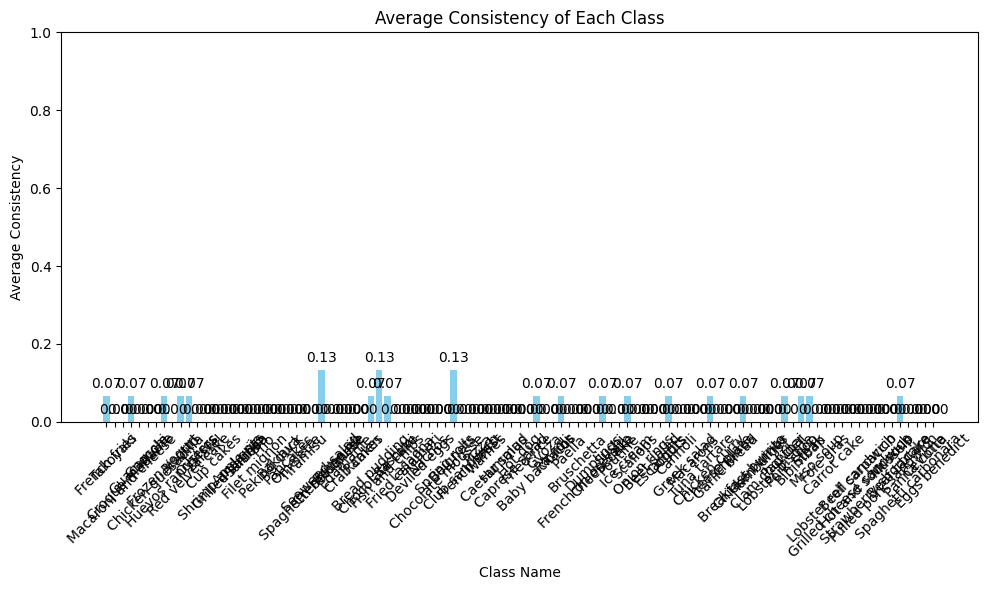

In [ ]:
# k = 15
avg_consistency_15, class_consistency_15 = calculate_consistency(image_loader, labels, k=15)
highest_15, lowest_15 = find_extreme_classes_consistency(class_consistency_15)
print(f'{avg_consistency_15=}\n{class_consistency_15=}')
print(f'Top 3: \n{highest_15=}\n{lowest_15=}')
plot_consistency(class_consistency_15)

## Per-sample Variation

**Definition:** Per-sample variation measures the model's uncertainty about the embedding vector of a data point. It captures how drastically an image's embedding changes under different data augmentations. For a single embedding `x` and a set of `n` transformations, we define its variation as the average sum of squared __cosine distances__ between `x` and its augmented versions `x_aug`.


### Task (50 points)

1. Define five data augmentation transforms (e.g., random cropping, flipping, color jittering).
2. Calculate the per-sample variation for each image embedding using the formula above.
3. Compute the average per-sample variation for each class and the overall average across all classes. __Report these values and visualize the histogram.__
4. Identify the top 3 classes with the **highest** and **lowest** per-sample variation.
5. Compare these class-wise per-sample variation scores with the corresponding zero-shot accuracy performance.
6. Based on the comparison, draw conclusions about the relationship between per-sample variation and zero-shot accuracy in this specific scenario.

In [ ]:
# Define data augmentation transforms
data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(),
    transforms.RandomRotation(20),
    transforms.RandomGrayscale()
])

class TransformWrapper(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx].copy()
        if self.transform:
            x['image'] = self.transform(x['image'])
        return x

transformed_dataset = TransformWrapper(dataset, transform=data_transforms)
transformed_dataset[0]

{'image': <PIL.Image.Image image mode=RGB size=224x224>, 'label': 40}

In [ ]:
transformed_image_embeddings_dataset = create_image_embeddings_dataset(vlm, transformed_dataset)
print(f'{len(transformed_image_embeddings_dataset)=}')
transformed_image_loader = DataLoader(transformed_image_embeddings_dataset, batch_size=256, shuffle=False)

100%|██████████| 3/3 [01:02<00:00, 20.79s/it]

len(transformed_image_embeddings_dataset)=5002


In [ ]:
def calculate_variation(image_loader, transformed_image_loader):
    variations = []
    labels = []
    # iter = 0
    for (embedding, label), (transformed_embedding, transformed_label) in zip(image_loader, transformed_image_loader):
        # iter += 1
        # print(f'{iter=}')
        assert all(label == transformed_label)
        vars = (1 - F.cosine_similarity(embedding, transformed_embedding, dim=-1)) ** 2
        variations.extend(vars)
        labels.extend(label)

    return np.array(variations), np.array(labels)

In [ ]:
def aggregate_variations(variations, labels, class_name):
    unique_labels = np.unique(labels)
    class_variations = {label: [] for label in unique_labels}

    for variation, label in zip(variations, labels):
        class_variations[label].append(variation)

    avg_class_variation = {class_name[label]: np.mean(variations) for label, variations in class_variations.items()}
    overall_avg_variation = np.mean(list(avg_class_variation.values()))

    return avg_class_variation, overall_avg_variation

def find_extreme_classes_variation(avg_class_variation):
    sorted_variations = sorted(avg_class_variation.items(), key=lambda x: x[1])
    lowest = sorted_variations[:3]
    highest = sorted_variations[-3:][::-1]
    return highest, lowest

def visualize_histogram(avg_class_variation):
    plt.figure(figsize=(10, 6))
    plt.hist(avg_class_variation.values(), bins=10, alpha=0.75)
    plt.xlabel('Average Per-sample Variation')
    plt.ylabel('Number of Classes')
    plt.title('Histogram of Average Per-sample Variation Across Classes')
    plt.show()

Average: 0.0012274743057787418
Top 3:
highest=[('Miso soup', 0.003380424), ('Eggs benedict', 0.0033225417), ('Filet mignon', 0.002795666)]
lowest=[('Ice cream', 0.00024515935), ('Oysters', 0.00025543512), ('Sushi', 0.00044729313)]


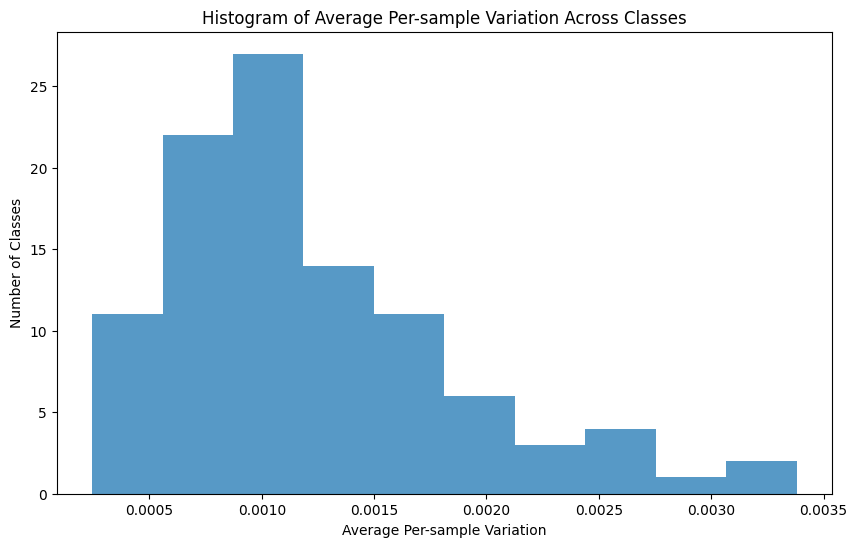

In [ ]:
# Conclusion & Report
variations, label_list = calculate_variation(image_loader, transformed_image_loader)
avg_class_variation, overall_avg_variation = aggregate_variations(variations, label_list, labels)
highest, lowest = find_extreme_classes_variation(avg_class_variation)
print(f'Average: {overall_avg_variation}')
print(f'Top 3:\n{highest=}\n{lowest=}')
visualize_histogram(avg_class_variation)

# Text Embedding Analytics

## Fine-grained Label Set


**In `label_mapping.py`, each class has around 50 detailed labels. Use the `create_label_embeddings_dataset` function to calculate label embeddings for this new set.**

### Task (15 points)
- Visualize the embeddings of these fine-grained labels alongside the original labels, using larger data points for the original labels. Set the `alpha` value to 0.4 for the new label set. Additionally, assign distinct colors to each class and include a legend for clarity.

In [ ]:
def update_embedding(labels, label_mapping):
    new_labels = list(itertools.chain(*[label_mapping[label.lower()] for label in labels]))
    annotation_df = pd.DataFrame({
        'label': new_labels,
        'class_id': range(len(new_labels))
    })

    class_id_to_label = pd.Series(annotation_df.label.values, index=annotation_df.class_id).to_dict()
    new_label_embeddings_dataset = create_label_embeddings_dataset(vlm, class_id_to_label, templates=[default_prompt_template])
    print(f'{len(new_label_embeddings_dataset)=}')
    new_label_loader = DataLoader(new_label_embeddings_dataset, batch_size=1024, shuffle=False)

    return new_labels, new_label_loader

100%|██████████| 4244/4244 [00:44<00:00, 94.87it/s]
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


len(new_label_embeddings_dataset)=4244


<ipython-input-28-58534ca92e18>:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))  # Get a colormap with enough colors
<ipython-input-28-58534ca92e18>:47: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


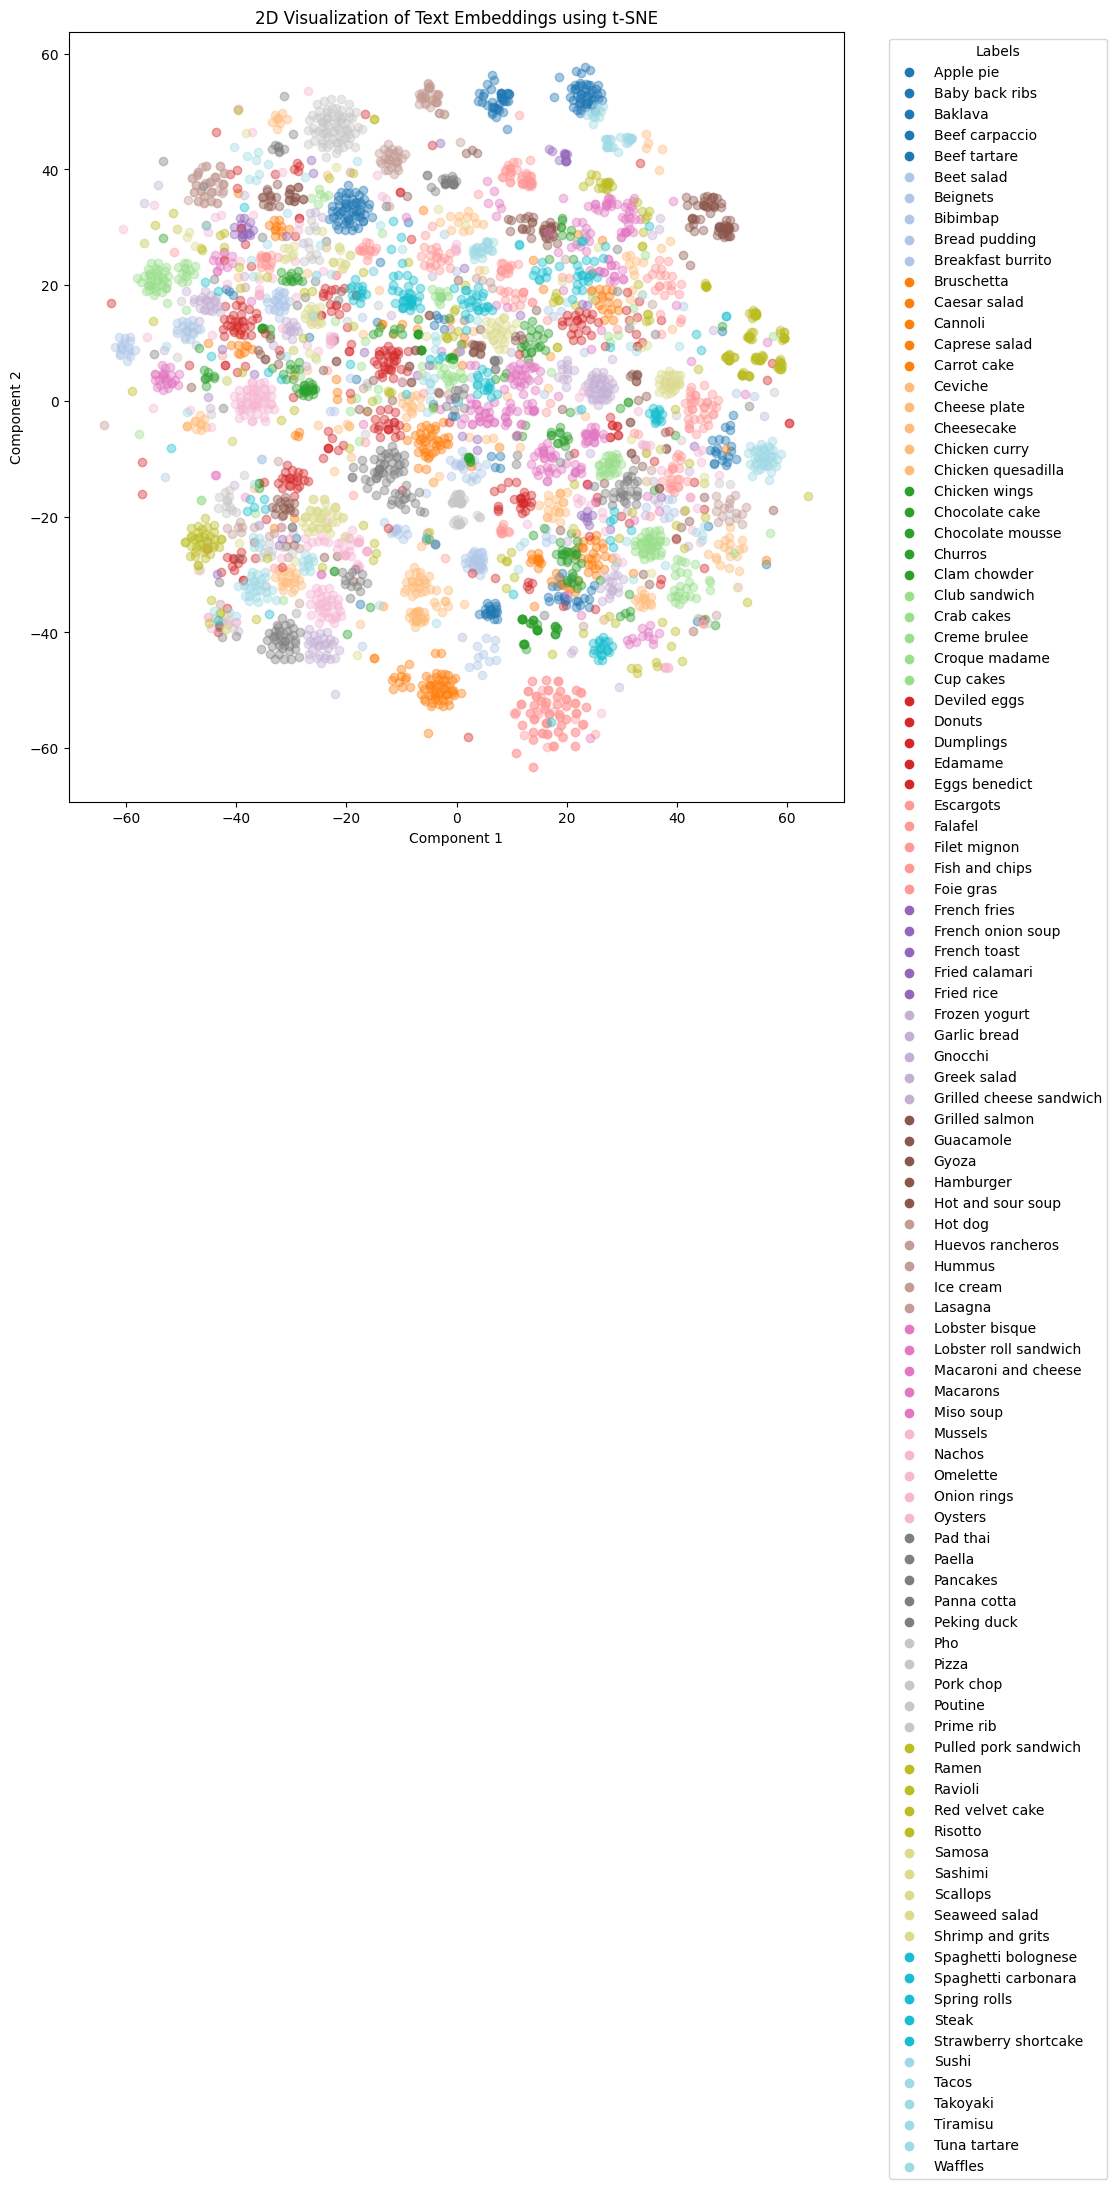

In [ ]:
from label_mapping import label_mapping


# Initial texts embeddings
text_embeddings = torch.cat([texts_list[0] for texts_list in label_loader])
text_embeddings = text_embeddings.cpu().numpy()

new_labels, new_label_loader = update_embedding(labels, label_mapping)
new_text_embeddings = torch.cat([texts_list[0] for texts_list in new_label_loader])
new_text_embeddings = new_text_embeddings.cpu().numpy()

# Dimensionality Reduction with t-SNE
tsne_model = TSNE(n_components=2, random_state=SEED, perplexity=30, learning_rate=200)
text_embeddings_2d = tsne_model.fit_transform(text_embeddings)

new_tsne_model = TSNE(n_components=2, random_state=SEED, perplexity=30, learning_rate=200)
new_text_embeddings_2d = tsne_model.fit_transform(new_text_embeddings)


# Unique labels in your dataset
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap('tab20', len(unique_labels))  # Get a colormap with enough colors

plt.figure(figsize=(10, 10))

# First plot the original embeddings
for i, label in enumerate(unique_labels):
    idxs = np.where(np.array(labels) == label)
    plt.scatter(text_embeddings_2d[idxs, 0], text_embeddings_2d[idxs, 1],
                alpha=1, color=colors(i), label=label)

# Then plot the new embeddings
class_len = [len(v) for _, v in label_mapping.items()]
class_final_index = [sum(class_len[:i+1]) for i in range(len(class_len))]
class_indices = [(0, class_final_index[0])] + [(class_final_index[i], class_final_index[i + 1]) for i in range(len(class_final_index) - 1)]


for i, label in enumerate(unique_labels):
    idx = class_indices[i]
    plt.scatter(new_text_embeddings_2d[idx[0]:idx[1], 0], new_text_embeddings_2d[idx[0]:idx[1], 1],
                alpha=0.4, color=colors(i))

plt.title('2D Visualization of Text Embeddings using t-SNE')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend placement to avoid overlap
plt.tight_layout()
plt.show()

### Task (10 points)
Calculate the average embedding vector (centroid) for each class using the new labels, and visualize these protype s along with the original labels.

<ipython-input-29-8e8604abe400>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(unique_labels))  # Get a colormap with enough colors
<ipython-input-29-8e8604abe400>:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


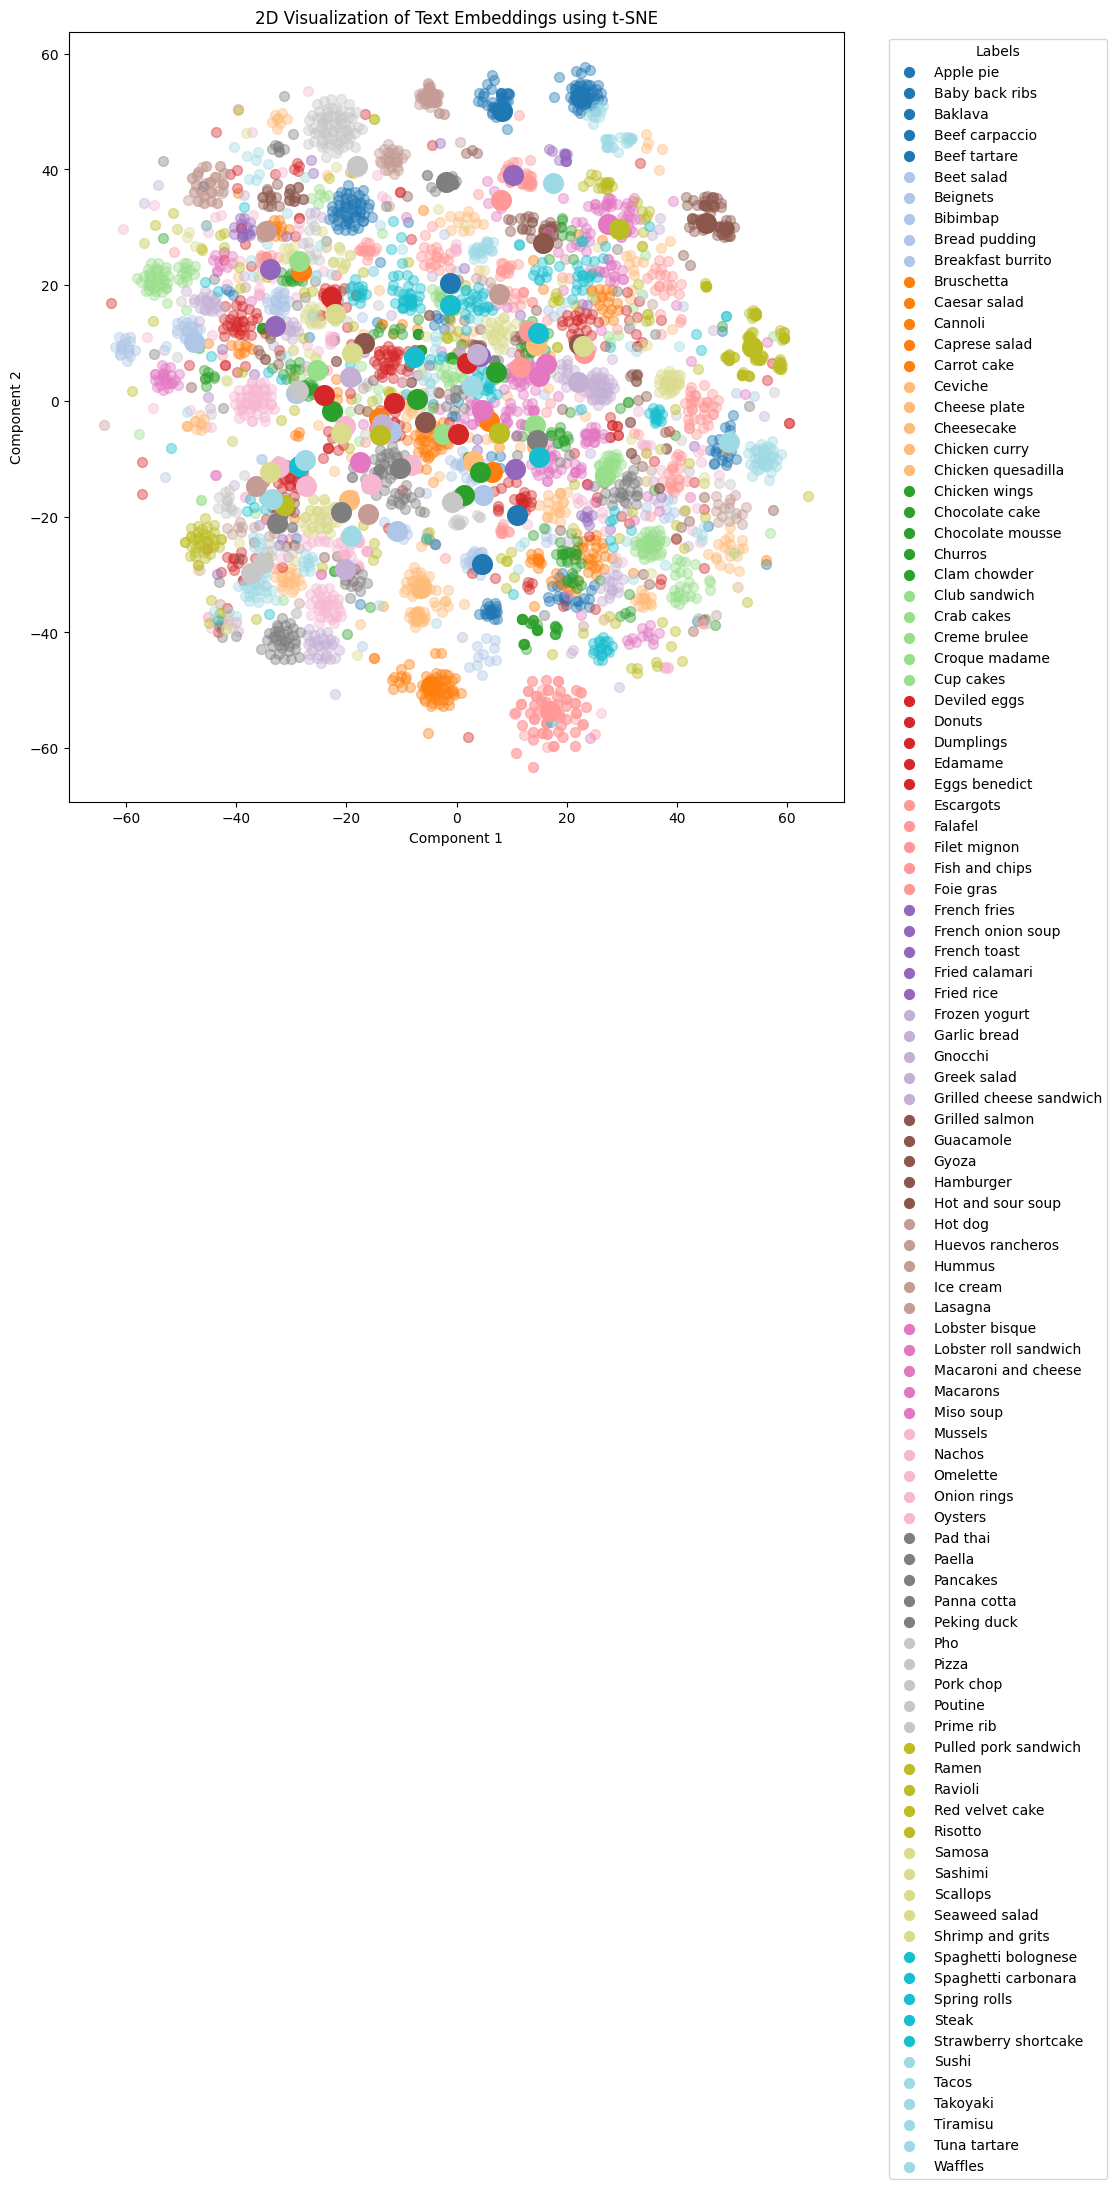

In [ ]:
# TODO
# Unique labels in your dataset
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap('tab20', len(unique_labels))  # Get a colormap with enough colors

plt.figure(figsize=(10, 10))

# First plot the original embeddings
for i, label in enumerate(unique_labels):
    idxs = np.where(np.array(labels) == label)
    plt.scatter(text_embeddings_2d[idxs, 0], text_embeddings_2d[idxs, 1],
                alpha=1, s=50, color=colors(i), label=label)

# Then plot the new embeddings
class_len = [len(v) for _, v in label_mapping.items()]
class_final_index = [sum(class_len[:i+1]) for i in range(len(class_len))]
class_indices = [(0, class_final_index[0])] + [(class_final_index[i], class_final_index[i + 1]) for i in range(len(class_final_index) - 1)]


for i, label in enumerate(unique_labels):
    idx = class_indices[i]
    plt.scatter(new_text_embeddings_2d[idx[0]:idx[1], 0], new_text_embeddings_2d[idx[0]:idx[1], 1],
                alpha=0.4, s=50, color=colors(i))

for i, label in enumerate(unique_labels):
    idx = class_indices[i]
    plt.scatter(new_text_embeddings_2d[idx[0]:idx[1], 0].mean(), new_text_embeddings_2d[idx[0]:idx[1], 1].mean(),
            alpha=1, s=200, color=colors(i))

plt.title('2D Visualization of Text Embeddings using t-SNE')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend placement to avoid overlap
plt.tight_layout()
plt.show()

### Task (10 points)
Re-evaluate the zero-shot accuracy using the new class representations. Compare this with the original accuracy and discuss the observed changes.

  0%|          | 0/20 [00:00<?, ?it/s]<ipython-input-30-2cc0731ba8eb>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(class_ids).cpu()
100%|██████████| 20/20 [00:01<00:00, 15.53it/s]


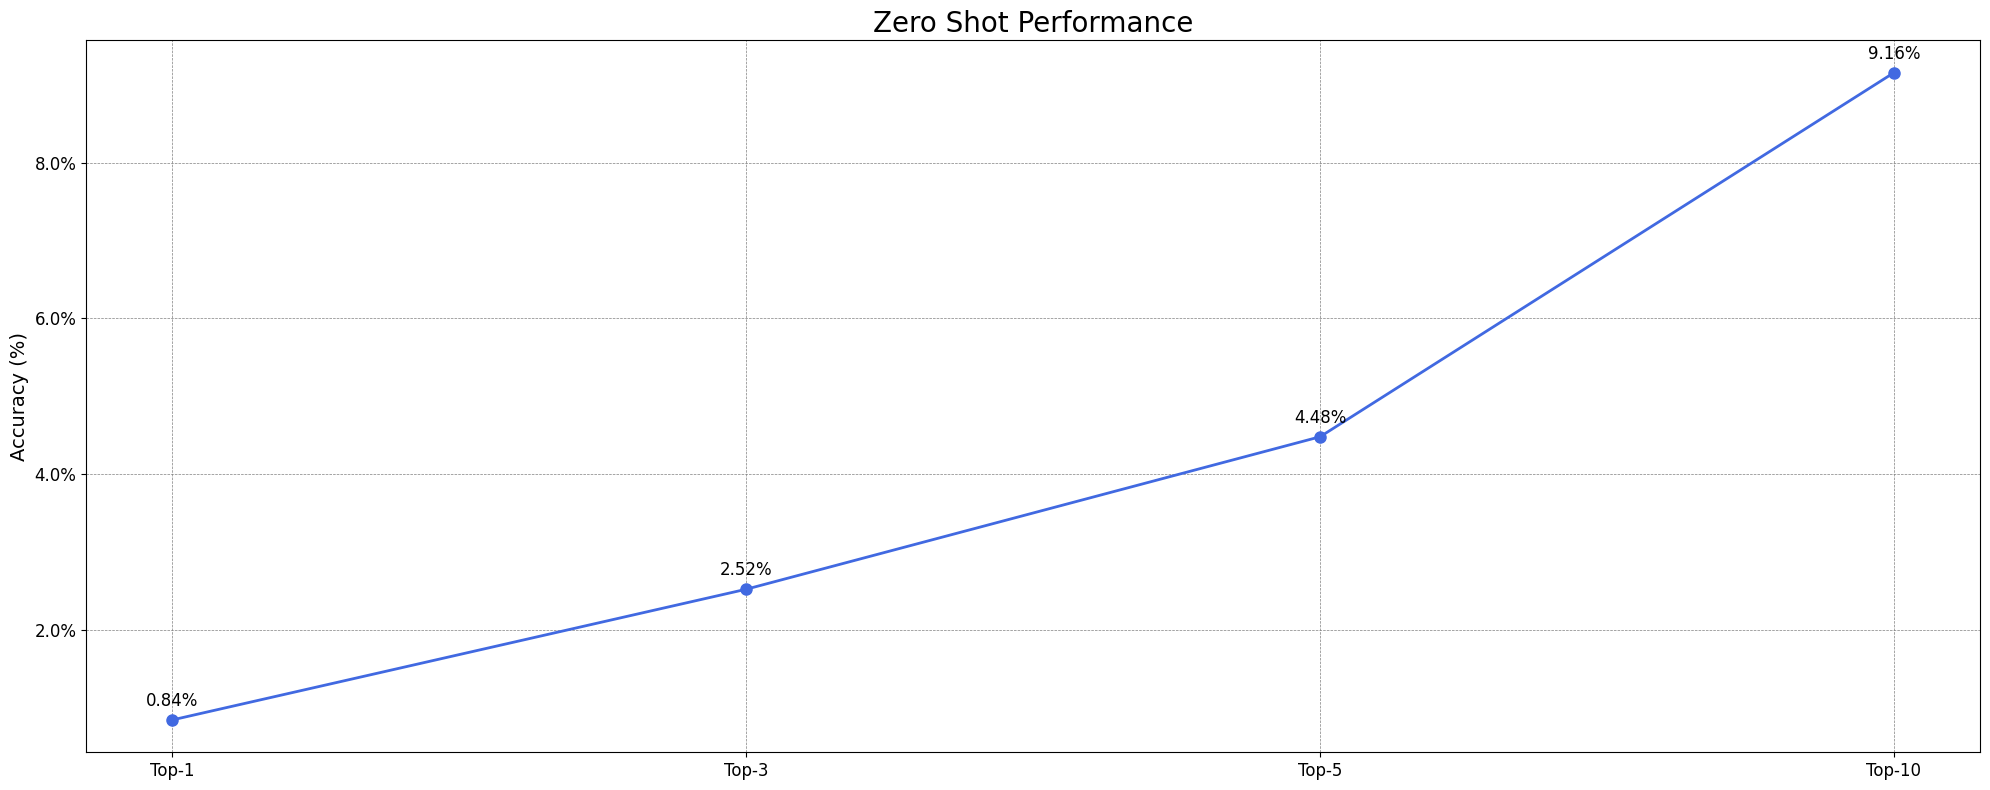

In [ ]:
@torch_decorator(device=device, no_grad=True)
def get_zero_shot_performance_updated(image_loader, label_loader, vlm, top_k):
    n, num_classes = 0, len(label_loader.dataset.labels)
    num_queries_per_label = label_loader.dataset.embeddings.shape[0] // num_classes
    n = 0
    top_k_accuracies = {k: 0. for k in top_k}
    class_wise_accuracies = {k: torch.zeros(num_classes) for k in top_k}
    class_counts = torch.zeros(num_classes)
    logit_scale = vlm.get_logit_scale().cpu()

    label_embeddings =  torch.transpose(label_loader.dataset.embeddings, 0, 1).float().cpu()

    for images, class_ids in tqdm(image_loader):
        images = images.float().cpu()
        target = torch.tensor(class_ids).cpu()
        image_features = images / images.norm(dim=-1, keepdim=True)
        target_embeddings = []

        logits = (logit_scale * image_features @ label_embeddings).view(images.shape[0], num_classes, num_queries_per_label)
        logits = torch.mean(logits, dim=2).softmax(dim=-1)
        logits_like_target = torch.zeros((target.shape[0], len(labels)))
        for i, (start, end) in enumerate(class_indices):
            logits_like_target[:, i] = logits[:, start:end].mean(dim=-1)
        acc = accuracy(logits_like_target, target, topk=top_k)
        for idx, k in enumerate(top_k):
            top_k_accuracies[k] += acc[idx]

        for i in range(target.size(0)):
            class_counts[target[i]] += 1
            for k in top_k:
                if target[i] in logits[i].topk(k).indices:
                    class_wise_accuracies[k][target[i]] += 1

        n += images.size(0)

    for k in top_k:
        top_k_accuracies[k] = (top_k_accuracies[k] / n) * 100
        class_wise_accuracies[k] = (class_wise_accuracies[k] / (class_counts * num_queries_per_label)) * 100

    return top_k_accuracies, class_wise_accuracies

top_k =(1, 3, 5, 10)

top_k_accuracies, class_wise_top_k_accuracies = get_zero_shot_performance_updated(
    image_loader,
    new_label_loader,
    vlm,
    top_k=top_k,
)

plot_accuracy_histogram(list(top_k_accuracies.values()), top_k)

## Compare With LLMs

### Task (20 points)
1. Use the `BAAI/bge-small-en-v1.5` model from Huggingface.
2. Visualize the embeddings of the LLM, similar to the setup for the fine-grained labels.

In [ ]:
def llm_embedding(labels, label_mapping, model):
    annotation_df = pd.DataFrame({
        'label': labels,
        'class_id': range(len(labels))
    })

    class_id_to_label = pd.Series(annotation_df.label.values, index=annotation_df.class_id).to_dict()
    label_embeddings_dataset = create_llm_label_embeddings_dataset(model, class_id_to_label, templates=[default_prompt_template])
    print(f'{len(label_embeddings_dataset)=}')
    label_loader = DataLoader(label_embeddings_dataset, batch_size=1024, shuffle=False)

    new_labels = list(itertools.chain(*[label_mapping[label.lower()] for label in labels]))
    annotation_df = pd.DataFrame({
        'label': new_labels,
        'class_id': range(len(new_labels))
    })

    class_id_to_label = pd.Series(annotation_df.label.values, index=annotation_df.class_id).to_dict()
    new_label_embeddings_dataset = create_llm_label_embeddings_dataset(model, class_id_to_label, templates=[default_prompt_template])
    print(f'{len(new_label_embeddings_dataset)=}')
    new_label_loader = DataLoader(new_label_embeddings_dataset, batch_size=1024, shuffle=False)

    return label_loader, new_label_loader

In [ ]:
@torch_decorator(device=device, no_grad=True)
def create_llm_label_embeddings_dataset(llm, target_id_to_target, templates, aggregate=False, device=device):
    all_embeddings, all_ids = [], []
    for target_id, target in tqdm(target_id_to_target.items()):
        texts = [template.format(target) for template in templates]
        text = "Your example text here."

        # Tokenize the text
        inputs = tokenizer(text, return_tensors="pt")

        # Get model's output
        outputs = model(**inputs)
        # print(f'{outputs.shape=}')

        # Extract embeddings (for example, using the last hidden state)
        embeddings = outputs.last_hidden_state
        # print(f'{embeddings.shape=}')

        # Optionally, average the embeddings for a single vector (simple approach)
        mean_embedding = embeddings.mean(dim=1)
        # print(f'{mean_embedding.shape=}')
        if aggregate:
            all_embeddings.append(embeddings.mean(dim=0))
            all_ids.append(target_id)
        else:
            for j in range(len(texts)):
                all_embeddings.append(embeddings[j])
            all_ids.extend([target_id] * len(texts))

    all_embeddings = torch.stack(all_embeddings, dim=0)
    all_embeddings = all_embeddings / all_embeddings.norm(dim=-1, keepdim=True)
    return EmbeddingDataset(all_embeddings.squeeze(), all_ids)

In [ ]:
import gc
gc.collect()

109061

In [ ]:
from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-small-en-v1.5")
model = AutoModel.from_pretrained("BAAI/bge-small-en-v1.5")

# TODO
llm_label_loader, llm_new_label_loader = llm_embedding(labels, label_mapping, model)
exit()
# Initial texts embeddings
text_embeddings = torch.cat([texts_list for texts_list in llm_label_loader])
text_embeddings = text_embeddings.cpu().numpy()

new_labels, new_label_loader = update_embedding(labels, label_mapping)
new_text_embeddings = torch.cat([texts_list for texts_list in llm_new_label_loader])
new_text_embeddings = new_text_embeddings.cpu().numpy()

# Dimensionality Reduction with t-SNE
tsne_model = TSNE(n_components=2, random_state=SEED, perplexity=30, learning_rate=200)
text_embeddings_2d = tsne_model.fit_transform(text_embeddings)

new_tsne_model = TSNE(n_components=2, random_state=SEED, perplexity=30, learning_rate=200)
new_text_embeddings_2d = tsne_model.fit_transform(new_text_embeddings)


# Unique labels in your dataset
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap('tab20', len(unique_labels))  # Get a colormap with enough colors

plt.figure(figsize=(10, 10))

# First plot the original embeddings
for i, label in enumerate(unique_labels):
    idxs = np.where(np.array(labels) == label)
    plt.scatter(text_embeddings_2d[idxs, 0], text_embeddings_2d[idxs, 1],
                alpha=1, color=colors(i), label=label)

# Then plot the new embeddings
class_len = [len(v) for _, v in label_mapping.items()]
class_final_index = [sum(class_len[:i+1]) for i in range(len(class_len))]
class_indices = [(0, class_final_index[0])] + [(class_final_index[i], class_final_index[i + 1]) for i in range(len(class_final_index) - 1)]


for i, label in enumerate(unique_labels):
    idx = class_indices[i]
    plt.scatter(new_text_embeddings_2d[idx[0]:idx[1], 0], new_text_embeddings_2d[idx[0]:idx[1], 1],
                alpha=0.4, color=colors(i))

plt.title('2D Visualization of Text Embeddings using t-SNE')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend(title='Labels', bbox_to_anchor=(1.05, 1), loc='upper left')  # Adjust legend placement to avoid overlap
plt.tight_layout()
plt.show()

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

100%|██████████| 101/101 [00:02<00:00, 35.28it/s]


len(label_embeddings_dataset)=101


100%|██████████| 4244/4244 [01:58<00:00, 35.78it/s]


len(new_label_embeddings_dataset)=4244


100%|██████████| 4244/4244 [00:44<00:00, 96.02it/s]
/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


len(new_label_embeddings_dataset)=4244


ValueError: data should be two dimensional

### Per-sample Variation Comparison
### Task (40 points)
- Calculate the average per-sample variation for both CLIP's text encoder and the LLM using cosine distance as the metric.
- Compare the average per-sample variation values. This comparison can offer insights into:
  - Model Uncertainty: A higher per-sample variation in the LLM might indicate greater uncertainty about its  representations compared to CLIP, potentially impacting tasks like classification.
  - Representation Differences: Variations in per-sample variation suggest differences in how each model handles data augmentations, potentially impacting their robustness and generalization.

- Compare the embeddings of the CLIP's text encoder with the LLM and briefly justify your conclusion.

In [ ]:
# TODO
def calculate_variation(vlm_loader, llm_loader):
    variations = []
    labels = []
    # iter = 0
    for vlm_label, llm_label in zip(vlm_loader, llm_loader):
        # iter += 1
        # print(f'{iter=}')
        vars = (1 - F.cosine_similarity(vlm_label[0], llm_label[0], dim=-1)) ** 2
        variations.extend(vars)

    return np.array(variations).mean()

# Final Question (10 + 10 points)

__Scenario:__ We aim to fine-tune the CLIP model on this dataset, but with limited resources allowing __only one encoder (image or text)__ to be adjusted.

__Question__: Based on your previous analysis, please select your choice and provide your justification in no more than three sentences.

__Note on the extra 10 ponits__: Only for providing further justification (in addition to your own), supported by a reference to a relevant paper.

I would choose to fine-tune the text encoder of the CLIP model. Text embeddings often capture more abstract semantic information, enabling better understanding of concepts and relationships within the dataset, which can generalize across a wider range of tasks. Additionally, recent studies have shown the effectiveness of pretraining text encoders on large corpora for improving performance on downstream tasks, supporting the choice of adjusting the text encoder. For example, the paper "Language Models are Few-Shot Learners" by Brown et al. (2020) demonstrates the impressive capabilities of text encoders in understanding and generalizing across diverse tasks.